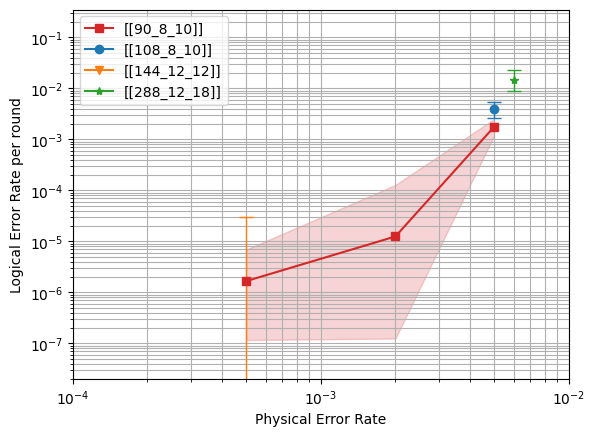

In [4]:
import matplotlib.pyplot as plt
import sinter 
import re


collected_stats = sinter.stats_from_csv_files(f'../collected_stats/collected_stats_pauses.csv')


fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['nkd'],
    failure_units_per_shot_func = lambda stats: stats.json_metadata['r'], # set as num_rounds ('r') failure units to find pL per round
    filter_func=lambda s: s.json_metadata['T2'] == 10 and s.json_metadata['pause'] == 0
)

ax.loglog()
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per round")
ax.legend()
ax.grid()
ax.grid(True, which = 'minor')
# fig.set_dpi(120)  # Show it bigger
ax.set_ylim(2e-8, 3.5e-1)
ax.set_xlim(1e-4, 1e-2)


ax.legend(*zip(*sorted(zip(*ax.get_legend_handles_labels()), key=lambda x: tuple(map(int, re.findall(r'\d+', x[1]))))))  # sort legend labels by number of qubits


# ax.figure.savefig(f"../plots/tham_modules_noise.png", dpi = 300, bbox_inches = "tight")
ax.figure.savefig(f"../plots/scrap.png", dpi = 300, bbox_inches = "tight")

In [5]:
for stat in collected_stats:
    print(stat)

    240348,         4,         0,145423.5,bposd,e9169ff41eea67d183fe2aa10b1355909c9361ce9e237b5f08d8d1421327483a,"{""A"":""'900102'"",""B"":""'002070'"",""T2"":10,""b"":""X"",""l"":15,""m"":3,""nkd"":""[[90_8_10]]"",""noise"":""uniform_plus_shift_and_shuttle_w_dephasing_idling"",""p"":0.0005,""pause"":0,""r"":10,""seq_gates"":""True""}",
     31256,         0,         0,145510.4,bposd,d5d688d5d6dc453bee1db72feb376b2ec28c43f23200acdb8cd0d8e23498c3b1,"{""A"":""'900102'"",""B"":""'002070'"",""T2"":10,""b"":""Z"",""l"":15,""m"":3,""nkd"":""[[90_8_10]]"",""noise"":""uniform_plus_shift_and_shuttle_w_dephasing_idling"",""p"":0.0005,""pause"":""T2over15"",""r"":10,""seq_gates"":""True""}",
      2941,       100,         0, 16202.2,bposd,042692cb85ed7ced9448daf310e8744825634ff1b4471a418677d370ffdecc54,"{""A"":""'300102'"",""B"":""'031020'"",""T2"":50,""b"":""X"",""l"":9,""m"":6,""nkd"":""[[108_8_10]]"",""noise"":""uniform_plus_shift_and_shuttle_w_dephasing_idling"",""p"":0.002,""pause"":""T2ove